## The Transform  Matrix Revisited

우리는 앞선 동차 행렬을 이용하여 변환 공식을 하나의 행렬로 나타낼 수 있다.

$$F = M \cdot P \cdot C_{R}^{-1} \cdot C_{T}^{-1} \cdot I_{T} \cdot I_{R} \cdot I_{S}$$

이제 vertex를 옮기는 것은 다음과 같은 식으로 따르게 된다.

$$V' = F \cdot V$$

나아가, 우리는 변환 행렬은 다음과 같이 분해할 수 있다.

$$M_{Projection} = M \cdot P$$
$$M_{Camera} = C_{R}^{-1} \cdot C_{T}^{-1}$$
$$M_{Model} = I_{T} \cdot I_{R} \cdot I_{S}$$
$$M = M_{Projection} \cdot M_{Camera} \cdot M_{Model}$$

In [6]:
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt

In [27]:
def rotation_matrix(orientation):
    x_rotate = np.array([[1, 0, 0, 0],
                   [0, math.cos(math.pi * orientation[0] / 180), (math.sin(math.pi * orientation[0] / 180)), 0],
                   [0, -(math.sin(math.pi * orientation[0] / 180)), math.cos(math.pi * orientation[0] / 180), 0],
                    [0, 0, 0, 1]])
    y_rotate = np.array([[math.cos(math.pi * orientation[1] / 180),0,-(math.sin(math.pi * orientation[1] / 180)), 0],
               [0, 1, 0, 0],
               [(math.sin(math.pi * orientation[1] / 180)), 0, math.cos(math.pi * orientation[1] / 180), 0],
                [0, 0, 0, 1]])
    z_rotate = np.array([[math.cos(math.pi * orientation[2] / 180), (math.sin(math.pi * orientation[2] / 180)), 0, 0],
               [-(math.sin(math.pi * orientation[2] / 180)), math.cos(math.pi * orientation[2] / 180), 0, 0],
               [0, 0, 1, 0],
                [0, 0, 0, 1]])
    
    return np.dot(np.dot(x_rotate, y_rotate), z_rotate)

def translate_matrix(position):
    return np.array([[1, 0, 0, position[0]],
                   [0, 1, 0, position[1]],
                   [0, 0, 1, position[2]],
                   [0, 0, 0, 1]])

def scale_matrix(scale):
    return np.array([[scale, 0, 0, 0],
                    [0, scale, 0, 0],
                    [0, 0, scale, 0],
                    [0, 0, 0, 1]])

In [8]:
class Point:
    def __init__(self, x, y, h, color=[255,255,255]):
        self.x = x
        self.y = y
        self.h = h
        self.color = color
        
class Vertex:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
        
class Vertex4:
    def __init__(self, x, y, z, w):
        self.x = x
        self.y = y
        self.z = z
        self.w = w

class Triangle:
    def __init__(self, v1,v2,v3,color):
        self.v = [v1,v2,v3]
        self.color = color
        
class Camera:
    def __init__(self,
                 position = [0,0,0],
                 orientation = [0,0,0],
                 viewport_size = 1,
                 projection_plane_z = 1
                 ):
        
        self.position = position
        self.orientation = orientation
        self.viewport_size = viewport_size
        self.projection_plane_z = projection_plane_z
        
class Model:
    def __init__(self, vertices, triangles):
        self.vertices = vertices
        self.triangles = triangles
        
class Instance:
    def __init__(self, model, position=[0,0,0], orientation=[0,0,0], scale=1):
        self.model = model
        self.position = position
        self.orientation = orientation
        self.scale = scale
        
        self.transform = np.dot(translate_matrix(self.position), np.dot(rotation_matrix(self.orientation), scale_matrix(self.scale)))

In [9]:
class Canvas:
    def __init__(self,
                 width=600, 
                 height=600):
        self.width = width
        self.height = height
        
        self.img = np.zeros((width,height,3), dtype = np.uint8) + 255
        
    def put_pixel(self, x, y, color,line_width):
        x = self.width/2 + x
        y = self.height/2 - y -1
        if (x< 0 or x >= self.width or y < 0 or y >= self.height):
            return 
        R = int(color[0])
        G = int(color[1])
        B = int(color[2])
        cv2.line(self.img, (int(x), int(y)), (int(x), int(y)), (R,G,B),line_width)
        

In [10]:
class Renderer:
    def __init__(self, camera, canvas):
        self.camera = camera
        self.canvas = canvas
        
    def draw_line(self, p0, p1, color, line_width=1):
        if np.abs(p0.x - p1.x) > abs(p0.y - p1.y):
            # line is horizontal-ish
            if p0.x > p1.x:
                p0, p1 = p1, p0
            
            ys = self.interpolate(p0.x,p0.y,p1.x,p1.y)

            for i in range(p1.x-p0.x+1):
                canvas.put_pixel(i+p0.x,ys[i],color,line_width)
                    
        else:
            # line is vertical-ish
                        # line is horizontal-ish
            if p0.y > p1.y:
                p0, p1 = p1, p0
            
            xs = self.interpolate(p0.y,p0.x,p1.y,p1.x)
            for i in range(p1.y-p0.y+1):
                canvas.put_pixel(xs[i], i+p0.y, color, line_width)
                
    
    def interpolate(self, i0, d0,i1, d1):
        if i0==i1:
            return [d0]
        else:
            values = []
            
            a = (d1-d0) / (i1 - i0)
            d = d0
            
            for i in range(i0, i1+1):
                values.append(d)
                d += a
            return values
        
    def draw_wire_triangle(self, p0, p1, p2, color, line_width = 1):
        self.draw_line(p0, p1, color, line_width)
        self.draw_line(p1, p2, color, line_width)
        self.draw_line(p0, p2, color, line_width)
        
    def draw_filled_triangle(self, p0, p1, p2, color, line_width = 1):
        # Sort the points so that y0 <= y1 <= y2
        if p1.y < p0.y:
            p1, p0 = p0, p1
        if p2.y < p0.y:
            p2, p0 = p0, p2
        if p2.y < p1.y:
            p1, p2 = p2, p1
        
        # Compute the x coordinates of the triangle edges
        x01 = self.interpolate(p0.y, p0.x, p1.y, p1.x)
        x12 = self.interpolate(p1.y, p1.x, p2.y, p2.x)
        x02 = self.interpolate(p0.y, p0.x, p2.y, p2.x)
        
        # Concatenate the short sides
        x01.pop(-1)
        x012 = x01 + x12
        
        # Determine which is left and which is right
        m = math.floor(len(x012)/2)
        if x02[m] < x012[m]:
            x_left = x02
            x_right= x012
        else:
            x_left = x012
            x_right = x02
            
        # Draw the horizontal segments
        for y in range(p0.y,p2.y):
            x_left_value = math.floor(x_left[y-p0.y])
            x_right_value = math.floor(x_right[y-p0.y])
            for x in range(x_left_value, x_right_value+1):
                canvas.put_pixel(x,y,color,line_width)
                
    def draw_shaded_triangle(self, p0, p1, p2, color, line_width):
        # Sort the points so that y0 <= y1 <= y2
        if p1.y < p0.y:
            p1, p0 = p0, p1
        if p2.y < p0.y:
            p2, p0 = p0, p2
        if p2.y < p1.y:
            p1, p2 = p2, p1
            
        # Compute the x coordinates and h values of the triangle edges
        x01 = self.interpolate(p0.y, p0.x, p1.y, p1.x)
        h01 = self.interpolate(p0.y, p0.h, p1.y, p1.h)
        
        x12 = self.interpolate(p1.y, p1.x, p2.y, p2.x)
        h12 = self.interpolate(p1.y, p1.h, p2.y, p2.h)
        
        x02 = self.interpolate(p0.y, p0.x, p2.y, p2.x)
        h02 = self.interpolate(p0.y, p0.h, p2.y, p2.h)
        
        # Concatenate the short sides
        x01.pop(-1)
        x012 = x01 + x12
        
        h01.pop(-1)
        h012 = h01 + h12
        
        # Determine which is left and which is right
        m = math.floor(len(x012)/2)
        if x02[m] < x012[m]:
            x_left = x02
            h_left = h02
            
            x_right= x012
            h_right = h012
        else:
            x_left = x012
            h_left = h012
            
            x_right = x02
            h_right = h02
            
        # Draw the horizontal segments
        for y in range(p0.y,p2.y):
            x_l= math.floor(x_left[y-p0.y])
            x_r = math.floor(x_right[y-p0.y])
            
            h_segment = self.interpolate(x_l, h_left[y - p0.y], x_r, h_right[y - p0.y])
            for x in range(x_l, x_r + 1):
                shaded_color = np.dot(color, h_segment[x - x_l])
                canvas.put_pixel(x,y,shaded_color,line_width)
                
    def viewport_to_canvas(self, x, y):
        p = Point(int(x * (canvas.width / camera.viewport_size)), int(y * (canvas.height / camera.viewport_size)), h =1.0)
        return p
    
    def project_vertex(self, v):
        d = camera.projection_plane_z
        return self.viewport_to_canvas(v[0] * d / v[2], v[1] * d / v[2])
    
    def render_triangle(self, triangle, projected):
        
        self.draw_wire_triangle(projected[triangle.v[0]],
                           projected[triangle.v[1]],
                           projected[triangle.v[2]],
                           triangle.color)
        
    def render_model(self, model, transform):
        projected = []
        for vertex in model.vertices:
            vertex_h = Vertex4(vertex.x, vertex.y, vertex.z, 1)
            projected.append(self.project_vertex(np.dot(transform, np.array([vertex_h.x, vertex_h.y, vertex_h.z, vertex_h.w]))))
            
        for triangle in triangles:
            self.render_triangle(triangle, projected)
            
    def render_scene(self, instances):
        camera_matrix = np.dot(rotation_matrix(self.camera.orientation).T, translate_matrix(np.dot(-1, self.camera.position)))
        
        for instance in instances:
            transform = np.dot(camera_matrix, instance.transform)
            self.render_model(instance.model, transform)
            
    def render(self):
        plt.imshow(self.canvas.img)
        return

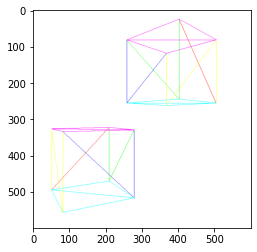

In [28]:
camera = Camera([-3,1,2], [0,-30,0], viewport_size = 1, projection_plane_z = 1)
canvas = Canvas(width=600, height=600)

renderer = Renderer(camera=camera, canvas=canvas)

vertices = [
    Vertex(1,1,1),
    Vertex(-1,1,1),
    Vertex(-1,-1,1),
    Vertex(1,-1,1),
    Vertex(1,1,-1),
    Vertex(-1,1,-1),
    Vertex(-1,-1,-1),
    Vertex(1,-1,-1)
]

triangles = [
    Triangle(0,1,2,(255,0,0)),
    Triangle(0,2,3,(255,0,0)),
    Triangle(4,0,3,(0,255,0)),
    Triangle(4,3,7,(0,255,0)),
    Triangle(5,4,7,(0,0,255)),
    Triangle(5,7,6,(0,0,255)),
    Triangle(1,5,6,(255,255,0)),
    Triangle(1,6,2,(255,255,0)),
    Triangle(4,5,1,(255,0,255)),
    Triangle(4,1,0,(255,0,255)),
    Triangle(2,6,7,(0,255,255)),
    Triangle(2,7,3,(0,255,255))
]

cube = Model(vertices, triangles)

instances = [Instance(cube, [-1.5, 0, 7], [0,0,0], 0.75),
            Instance(cube, [1.25, 2.5, 7.5], [0,195,0])]

renderer.render_scene(instances)
renderer.render()